In [1]:
import os
import sys
import yaml
import math
import pickle
import itertools
from copy import deepcopy

module_path = os.path.abspath(os.path.join('../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

import src.utils.numpy_nest_utils as np_nest
from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts, flatten_dict
from experiments.dispatch.dispatch_utils import nested_dict_to_option_strings

# plotting
%config InlineBackend.figure_formats = ['svg']

mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.preview'] = True
# mpl.rcParams['grid.linewidth']=0.2
mpl.rcParams['lines.linewidth']=1.0
# mpl.rcParams['axes.linewidth']=0.001
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['legend.fontsize'] = 7

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

mpl.rcParams['mathtext.fontset'] = 'cm'

text_width = 5.5

figsize = (text_width/1.5, text_width/1.2)

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
pvi_color = '#FF9900'
dp_pvi_colors = ['#660000', '#B20000', '#FF0000']
dp_pvi_colors.reverse()
batch_vi_color = '#007F28'
dp_batch_vi_colors = ['#00224C', '#0050B2', '#0073FF']
dp_batch_vi_colors.reverse()

# Comparison of two distributed VI mehtods, and their privatised counterparts

In [3]:
def combine_configs(*configs):
    ret = {}
    for config in configs:
        ret = {**ret, **config}
    return ret

homo_configs = [ {'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': val, 'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0} for val in [None, 0.5, 0.75, 1.0, 2.0, 3.0]]
inhomo_1_configs = [ {'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': val, 'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95} for val in [None, 0.5, 0.75, 1.0, 2.0, 3.0]]
inhomo_2_configs = [ {'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': val, 'dataset_dist.client_size_factor': 0.7, 'dataset_dist.class_balance_factor': -3} for val in [None, 0.5, 0.75, 1.0, 2.0, 3.0]]

dp_pvi_configs = {'experiment_tag': 'datapoint_dp_pvi'}
dp_batch_vi_configs = {'experiment_tag': 'dp_batch_vi'}
pvi_configs = {'experiment_tag': 'pvi'}
batch_vi_configs = {'experiment_tag': 'batch_vi'}

dp_pvi_homo_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_pvi_configs], homo_configs)]
dp_pvi_inhomo_1_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_pvi_configs], inhomo_1_configs)]
dp_pvi_inhomo_2_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_pvi_configs], inhomo_2_configs)]

dp_batch_vi_homo_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_batch_vi_configs], homo_configs)]
dp_batch_vi_inhomo_1_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_batch_vi_configs], inhomo_1_configs)]
dp_batch_vi_inhomo_2_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_batch_vi_configs], inhomo_2_configs)]

pvi_homo_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([pvi_configs], [{'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0}])]
pvi_inhomo_1_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([pvi_configs], [{'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95}])]
pvi_inhomo_2_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([pvi_configs], [{'dataset_dist.client_size_factor': 0.7, 'dataset_dist.class_balance_factor': -3}])]

batch_vi_homo_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([batch_vi_configs], [{'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0}])]
batch_vi_inhomo_1_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([batch_vi_configs], [{'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95}])]
batch_vi_inhomo_2_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([batch_vi_configs], [{'dataset_dist.client_size_factor': 0.7, 'dataset_dist.class_balance_factor': -3}])]

dp_pvi_homo_configs.reverse()
dp_pvi_inhomo_1_configs.reverse()
dp_pvi_inhomo_2_configs.reverse()
dp_batch_vi_homo_configs.reverse()
dp_batch_vi_inhomo_1_configs.reverse()
dp_batch_vi_inhomo_2_configs.reverse()
pvi_homo_configs.reverse()
pvi_inhomo_1_configs.reverse()
pvi_inhomo_2_configs.reverse()
batch_vi_homo_configs.reverse()
batch_vi_inhomo_1_configs.reverse()
batch_vi_inhomo_2_configs.reverse()

In [4]:
results_access = SacredExperimentAccess(database_name='epsilon_clipping_adult_0909')

In [5]:
dp_pvi_homo_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_pvi_homo_configs]
dp_pvi_inhomo_1_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_pvi_inhomo_1_configs]
dp_pvi_inhomo_2_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_pvi_inhomo_2_configs]

dp_batch_vi_homo_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_batch_vi_homo_configs]
dp_batch_vi_inhomo_1_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_batch_vi_inhomo_1_configs]
dp_batch_vi_inhomo_2_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_batch_vi_inhomo_2_configs]

# dp_pvi_homo_experiments = [results_access.get_experiments(complete=False, config=config) for config in dp_pvi_homo_configs]
# dp_pvi_inhomo_1_experiments = [results_access.get_experiments(complete=False, config=config) for config in dp_pvi_inhomo_1_configs]
# dp_pvi_inhomo_2_experiments = [results_access.get_experiments(complete=False, config=config) for config in dp_pvi_inhomo_2_configs]

# dp_batch_vi_homo_experiments = [results_access.get_experiments(complete=False, config=config) for config in dp_batch_vi_homo_configs]
# dp_batch_vi_inhomo_1_experiments = [results_access.get_experiments(complete=False, config=config) for config in dp_batch_vi_inhomo_1_configs]
# dp_batch_vi_inhomo_2_experiments = [results_access.get_experiments(complete=False, config=config) for config in dp_batch_vi_inhomo_2_configs]

dp_pvi_homo_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications", *[f"client_{i}.MomentAccountant.epsilon_time" for i in range(10)], *[f"client_{i}.MomentAccountant.epsilon_communications" for i in range(10)]]) for experiments in dp_pvi_homo_experiments]
dp_pvi_inhomo_1_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications", *[f"client_{i}.MomentAccountant.epsilon_time" for i in range(10)], *[f"client_{i}.MomentAccountant.epsilon_communications" for i in range(10)]]) for experiments in dp_pvi_inhomo_1_experiments]
dp_pvi_inhomo_2_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications", *[f"client_{i}.MomentAccountant.epsilon_time" for i in range(10)], *[f"client_{i}.MomentAccountant.epsilon_communications" for i in range(10)]]) for experiments in dp_pvi_inhomo_2_experiments]

dp_batch_vi_homo_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications", *[f"client_{i}.MomentAccountant.epsilon_time" for i in range(10)], *[f"client_{i}.MomentAccountant.epsilon_communications" for i in range(10)]]) for experiments in dp_batch_vi_homo_experiments]
dp_batch_vi_inhomo_1_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications", *[f"client_{i}.MomentAccountant.epsilon_time" for i in range(10)], *[f"client_{i}.MomentAccountant.epsilon_communications" for i in range(10)]]) for experiments in dp_batch_vi_inhomo_1_experiments]
dp_batch_vi_inhomo_2_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications", *[f"client_{i}.MomentAccountant.epsilon_time" for i in range(10)], *[f"client_{i}.MomentAccountant.epsilon_communications" for i in range(10)]]) for experiments in dp_batch_vi_inhomo_2_experiments]

pvi_homo_experiments = [results_access.get_experiments(complete=True, config=config) for config in pvi_homo_configs]
pvi_inhomo_1_experiments = [results_access.get_experiments(complete=True, config=config) for config in pvi_inhomo_1_configs]
pvi_inhomo_2_experiments = [results_access.get_experiments(complete=True, config=config) for config in pvi_inhomo_2_configs]

batch_vi_homo_experiments = [results_access.get_experiments(complete=True, config=config) for config in batch_vi_homo_configs]
batch_vi_inhomo_1_experiments = [results_access.get_experiments(complete=True, config=config) for config in batch_vi_inhomo_1_configs]
batch_vi_inhomo_2_experiments = [results_access.get_experiments(complete=True, config=config) for config in batch_vi_inhomo_2_configs]

pvi_homo_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications"]) for experiments in pvi_homo_experiments]
pvi_inhomo_1_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications"]) for experiments in pvi_inhomo_1_experiments]
pvi_inhomo_2_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications"]) for experiments in pvi_inhomo_2_experiments]

batch_vi_homo_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications"]) for experiments in batch_vi_homo_experiments]
batch_vi_inhomo_1_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications"]) for experiments in batch_vi_inhomo_1_experiments]
batch_vi_inhomo_2_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy_time", "test_all_time", "test_accuracy_communications", "test_all_communications"]) for experiments in batch_vi_inhomo_2_experiments]

In [6]:
# all_homo_configs = [*dp_pvi_homo_configs, *dp_batch_vi_homo_configs]
# all_inhomo_1_configs = [*dp_pvi_inhomo_1_configs, *dp_batch_vi_inhomo_1_configs]
# all_inhomo_2_configs = [*dp_pvi_inhomo_2_configs, *dp_batch_vi_inhomo_2_configs]

# all_homo_experiments = [*dp_pvi_homo_experiments, *dp_batch_vi_homo_experiments]
# all_inhomo_1_experiments = [*dp_pvi_inhomo_1_experiments, *dp_batch_vi_inhomo_1_experiments]
# all_inhomo_2_experiments = [*dp_pvi_inhomo_2_experiments, *dp_batch_vi_inhomo_2_experiments]

# all_homo_metrics = [*dp_pvi_homo_metrics, *dp_batch_vi_homo_metrics]
# all_inhomo_1_metrics = [*dp_pvi_inhomo_1_metrics, *dp_batch_vi_inhomo_1_metrics]
# all_inhomo_2_metrics = [*dp_pvi_inhomo_2_metrics, *dp_batch_vi_inhomo_2_metrics]

all_homo_configs = [*dp_pvi_homo_configs, *pvi_homo_configs, *batch_vi_homo_configs] # [*dp_pvi_homo_configs, *pvi_homo_configs, *batch_vi_homo_configs, *dp_batch_vi_homo_configs]
all_inhomo_1_configs = [*dp_pvi_inhomo_1_configs, *pvi_inhomo_1_configs, *batch_vi_inhomo_1_configs] # [*dp_pvi_inhomo_1_configs, *pvi_inhomo_1_configs, *batch_vi_inhomo_1_configs, *dp_batch_vi_inhomo_1_configs]
all_inhomo_2_configs = [*dp_pvi_inhomo_2_configs, *pvi_inhomo_2_configs, *batch_vi_inhomo_2_configs] # [*dp_pvi_inhomo_2_configs, *pvi_inhomo_2_configs, *batch_vi_inhomo_2_configs, *dp_batch_vi_inhomo_2_configs]

all_homo_experiments = [*dp_pvi_homo_experiments, *pvi_homo_experiments, *batch_vi_homo_experiments] # [*dp_pvi_homo_experiments, *pvi_homo_experiments, *batch_vi_homo_experiments, *dp_batch_vi_homo_experiments]
all_inhomo_1_experiments = [*dp_pvi_inhomo_1_experiments, *pvi_inhomo_1_experiments, *batch_vi_inhomo_1_experiments] # [*dp_pvi_inhomo_1_experiments, *pvi_inhomo_1_experiments, *batch_vi_inhomo_1_experiments, *dp_batch_vi_inhomo_1_experiments]
all_inhomo_2_experiments = [*dp_pvi_inhomo_2_experiments, *pvi_inhomo_2_experiments, *batch_vi_inhomo_2_experiments] # [*dp_pvi_inhomo_2_experiments, *pvi_inhomo_2_experiments, *batch_vi_inhomo_2_experiments, *dp_batch_vi_inhomo_2_experiments]

all_homo_metrics = [*dp_pvi_homo_metrics, *pvi_homo_metrics, *batch_vi_homo_metrics] # [*dp_pvi_homo_metrics, *pvi_homo_metrics, *batch_vi_homo_metrics, *dp_batch_vi_homo_metrics]
all_inhomo_1_metrics = [*dp_pvi_inhomo_1_metrics, *pvi_inhomo_1_metrics, *batch_vi_inhomo_1_metrics] # [*dp_pvi_inhomo_1_metrics, *pvi_inhomo_1_metrics, *batch_vi_inhomo_1_metrics, *dp_batch_vi_inhomo_1_metrics]
all_inhomo_2_metrics = [*dp_pvi_inhomo_2_metrics, *pvi_inhomo_2_metrics, *batch_vi_inhomo_2_metrics] # [*dp_pvi_inhomo_2_metrics, *pvi_inhomo_2_metrics, *batch_vi_inhomo_2_metrics, *dp_batch_vi_inhomo_2_metrics]


all_homo_configs_main_text = [*dp_pvi_homo_configs, *pvi_homo_configs, *batch_vi_homo_configs]
all_inhomo_1_configs_main_text = [*dp_pvi_inhomo_1_configs, *pvi_inhomo_1_configs, *batch_vi_inhomo_1_configs]
all_inhomo_2_configs_main_text = [*dp_pvi_inhomo_2_configs, *pvi_inhomo_2_configs, *batch_vi_inhomo_2_configs]

all_homo_experiments_main_text = [*dp_pvi_homo_experiments, *pvi_homo_experiments, *batch_vi_homo_experiments]
all_inhomo_1_experiments_main_text = [*dp_pvi_inhomo_1_experiments, *pvi_inhomo_1_experiments, *batch_vi_inhomo_1_experiments]
all_inhomo_2_experiments_main_text = [*dp_pvi_inhomo_2_experiments, *pvi_inhomo_2_experiments, *batch_vi_inhomo_2_experiments]

all_homo_metrics_main_text = [*dp_pvi_homo_metrics, *pvi_homo_metrics, *batch_vi_homo_metrics]
all_inhomo_1_metrics_main_text = [*dp_pvi_inhomo_1_metrics, *pvi_inhomo_1_metrics, *batch_vi_inhomo_1_metrics]
all_inhomo_2_metrics_main_text = [*dp_pvi_inhomo_2_metrics, *pvi_inhomo_2_metrics, *batch_vi_inhomo_2_metrics]

In [7]:
def plot_methods_comms_rounds(configs, experiments, metrics, metric_num=0, title=None, suppress_legend=False, fig_size=figsize):
    fig = plt.figure(figsize=fig_size)
    
    y_label = ""
    
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    
    pvi_best = None
    metric_name = None
    
    dp_pvi_color_id = 0
    dp_batch_vi_color_id = 0
    
    for i, (config, expeiment, metric) in enumerate(zip(configs, experiments, metrics)):
        if not len(metric) == 0:
            metric_name = metric[0][metric_num]["name"]
            
            values = []
            for m in metric:
                values.append(deepcopy(m[metric_num]['values']))
                
            maxlen=0
            for value in values:
                if len(value) > maxlen:
                    maxlen=len(value)
            for j, value in enumerate(values):
                if len(value) < maxlen:
                    values[j] = value + ([np.nan] * (maxlen - len(value)))
            values = np.array(values).T
            for m in metric:
                if len(m[metric_num]['steps']) == maxlen:
                    steps = np.array(m[metric_num]['steps'])
                    break
            mean = np.nanmean(values, axis=1)
            std = np.nanstd(values, axis=1)
            
            if expeiment[0]['config']['experiment_tag'] == 'datapoint_dp_pvi':
                color = dp_pvi_colors[dp_pvi_color_id]
                dp_pvi_color_id += 1
                label = 'DP-PVI: $\epsilon_{max}$ ' + f'= {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}'
            elif expeiment[0]['config']['experiment_tag'] == 'pvi':
                color = pvi_color
                label = f'PVI'
            elif expeiment[0]['config']['experiment_tag'] == 'dp_batch_vi':
                color = dp_batch_vi_colors[dp_batch_vi_color_id]
                dp_batch_vi_color_id += 1
                label = 'DP Global VI: $\epsilon_{max}$' + f' = {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}'
            elif expeiment[0]['config']['experiment_tag'] == 'batch_vi':
                color = batch_vi_color
                label = f'Global VI'
            else:
                print('no color found')
                color = colors[i]
                               
            if expeiment[0]['config']['experiment_tag'] == 'pvi':
                pvi_best = np.nanmax(mean)
            if 'pvi' in expeiment[0]['config']['experiment_tag']:
                ax1.plot(steps, mean, color=color, label=label)
                ax1.fill_between(steps, mean - std, mean + std, color=color, alpha=0.2)
            else:
                ax2.plot(steps, mean, color=color, label=label)
                ax2.fill_between(steps, mean - std, mean + std, color=color, alpha=0.2)
            
    if title is not None:
        plt.title(title)
        
    ax1.grid(True)
    
    if 'communication' in metric_name:
        ax1.set_xlabel('PVI Communications')
        ax2.set_xlabel('Global VI Communications')
    else:
        ax1.set_xlabel('PVI Time Proxy')
        ax2.set_xlabel('Global VI Time Proxy')
    

    if 'test_accuracy' in metric_name:
        ax1.set_ylabel('Test Accuracy (%)')
    elif 'test_all' in metric_name:
        ax1.set_ylabel('Test Average Log Likelihood')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    ax1.set_xlim(left=0)
    ax2.set_xlim(left=0)

    if not suppress_legend:
        plt.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)
        
    plt.tight_layout()
    return lines1+lines2, labels1+labels2


In [8]:
def plot_methods_eps(configs, experiments, metrics, metric_num=0, epsilon_metric_indicies=[0], title=None):
    plt.figure(figsize=(text_width,text_width/1.5))
    
    y_label = ""
    for i, (config, expeiment, metric) in enumerate(zip(configs, experiments, metrics)):
        if not len(metric) == 0:
            y_label=f'{metric[0][metric_num]["name"]}'.replace('_', ' ')
            values = []
            for m in metric:
                values.append(m[metric_num]['values'])
                eps = []
                for e_i in epsilon_metric_indicies:
                    e = []
                    for step in m[metric_num]['steps']:
                        e.append(m[e_i]['values'][m[e_i]['steps'].index(step)])
                    eps.append(e)
                eps = np.max(eps, axis=0)
                values = np.array(values).T
                plt.plot(eps, values, color=colors[i], label=f'max $\epsilon$ {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}: {np.max(values):0.3f}'.replace('_', ' '))
            
    if title is not None:
        plt.title(title)
    plt.grid('on')
    plt.xlabel('epsilon')
    plt.ylabel(y_label)
    plt.legend()

In [9]:
def plot_methods_eps_final_only(configs, experiments, metrics, dp_configs, dp_experiments, dp_metrics, metric_num=0, epsilon_metric_indicies=[0], title=None, suppress_legend=False, fig_size=figsize):
    plt.figure(figsize=fig_size)
    
    metric_name = None
    
    dp_pvi_color_id = 0
    dp_batch_vi_color_id = 0
        
    for i, (config, expeiment, metric) in enumerate(zip(dp_configs, dp_experiments, dp_metrics)):
        if not len(metric) == 0:
            metric_name = metric[0][metric_num]["name"]

            values = []
            eps = []
#             print(config)
            for m in metric:
                run_values = m[metric_num]['values'] # run metirc values
                run_epsilons = []
                for e_i in epsilon_metric_indicies:
#                     print(m[e_i]['values'])
                    run_epsilons.append(np.max(m[e_i]['values'])) # max epsilon for each client in the run
                        
                values.append(run_values[-1]) # add the best metric/epsilon pair to the group
                eps.append(np.max(run_epsilons))
                
            if expeiment[0]['config']['experiment_tag'] == 'datapoint_dp_pvi':
                color = dp_pvi_colors[dp_pvi_color_id]
                dp_pvi_color_id += 1
                label = 'DP-PVI: $\epsilon_{max}$ ' + f'= {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}'
            elif expeiment[0]['config']['experiment_tag'] == 'pvi':
                color = pvi_color
                label = f'PVI'
            elif expeiment[0]['config']['experiment_tag'] == 'dp_batch_vi':
                color = dp_batch_vi_colors[dp_batch_vi_color_id]
                dp_batch_vi_color_id += 1
                label = 'DP Global VI: $\epsilon_{max}$' + f' = {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}'
            elif expeiment[0]['config']['experiment_tag'] == 'batch_vi':
                color = batch_vi_color
                label = f'Global VI'
            else:
                print('no color found')
                color = colors[i]
                
            plt.scatter(eps, values, color=color, label=label)
            
    xlim = plt.xlim()        
    for i, (config, expeiment, metric) in enumerate(zip(configs, experiments, metrics)):
        if not len(metric) == 0:
            metric_name = metric[0][metric_num]["name"]

            values = []
#             print(config)
            for m in metric:
                values.append(np.max(m[metric_num]['values'])) # add the best metric/epsilon pair to the group
            max_value = np.max(values)
            
            if expeiment[0]['config']['experiment_tag'] == 'datapoint_dp_pvi':
                color = dp_pvi_colors[dp_pvi_color_id]
                dp_pvi_color_id += 1
                label = 'DP-PVI: $\epsilon_{max}$ ' + f'= {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}'
            elif expeiment[0]['config']['experiment_tag'] == 'pvi':
                color = pvi_color
                label = f'PVI'
            elif expeiment[0]['config']['experiment_tag'] == 'dp_batch_vi':
                color = dp_batch_vi_colors[dp_batch_vi_color_id]
                dp_batch_vi_color_id += 1
                label = 'DP Global VI: $\epsilon_{max}$' + f' = {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}'
            elif expeiment[0]['config']['experiment_tag'] == 'batch_vi':
                color = batch_vi_color
                label = f'Global VI'
            else:
                print('no color found')
                color = colors[i]
                
            plt.plot(plt.xlim(), [max_value, max_value], color=color, linestyle='--', label=label, linewidth=2)
    plt.xlim(xlim)
            
    if 'test_accuracy' in metric_name:
        plt.ylabel('Test Accuracy (%)')
    elif 'test_all' in metric_name:
        plt.ylabel('Test Average Log Likelihood')
        
    if title is not None:
        plt.title(title)
        
    plt.grid('on')
    plt.xlabel('$\epsilon_{max}$')
    if not suppress_legend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
        
    plt.tight_layout()

### Main text plots

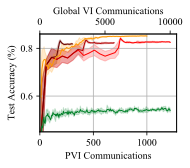

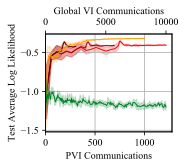

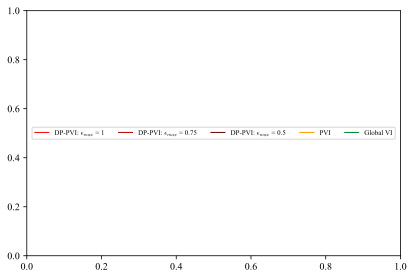

In [10]:
plot_methods_comms_rounds(all_inhomo_2_configs_main_text, all_inhomo_2_experiments_main_text, all_inhomo_2_metrics_main_text, metric_num=2, suppress_legend=True, fig_size=(text_width/2, text_width/2.2))
plt.ylim([0.45, 0.86])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_2_acc_comms_main_text.pdf', format='pdf')

lines, labels = plot_methods_comms_rounds(all_inhomo_2_configs_main_text, all_inhomo_2_experiments_main_text, all_inhomo_2_metrics_main_text, metric_num=3, suppress_legend=True, fig_size=(text_width/2, text_width/2.2))
# plt.ylim([0.70, 0.86])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_2_all_comms_main_text.pdf', format='pdf')

plt.figure()
plt.legend(lines, labels, ncol=5, loc='center')
plt.tight_layout()
plt.savefig('figs/legend.pdf', format='pdf')

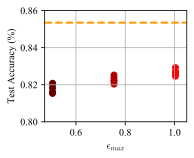

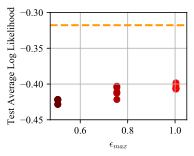

In [11]:
plot_methods_eps_final_only(pvi_inhomo_2_configs + batch_vi_inhomo_2_configs, pvi_inhomo_2_experiments + batch_vi_inhomo_2_experiments, pvi_inhomo_2_metrics + batch_vi_inhomo_2_metrics, dp_pvi_inhomo_2_configs, dp_pvi_inhomo_2_experiments, dp_pvi_inhomo_2_metrics, metric_num=0, epsilon_metric_indicies=[i+4 for i in range(10)], fig_size=(text_width/2, text_width/2.4), suppress_legend=True)
plt.ylim([0.8, 0.86])
plt.savefig('figs/inhomo_2_acc_best_main_text.pdf', format='pdf')


plot_methods_eps_final_only(pvi_inhomo_2_configs + batch_vi_inhomo_2_configs, pvi_inhomo_2_experiments + batch_vi_inhomo_2_experiments, pvi_inhomo_2_metrics + batch_vi_inhomo_2_metrics, dp_pvi_inhomo_2_configs, dp_pvi_inhomo_2_experiments, dp_pvi_inhomo_2_metrics, metric_num=1, epsilon_metric_indicies=[i+4 for i in range(10)], fig_size=(text_width/2, text_width/2.4), suppress_legend=True)
plt.ylim([-0.45, -0.3])
plt.savefig('figs/inhomo_2_all_best_main_text.pdf', format='pdf')

### Appendix plots

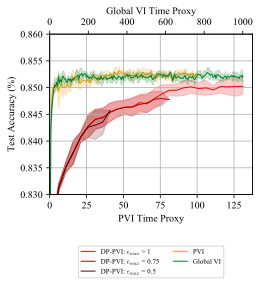

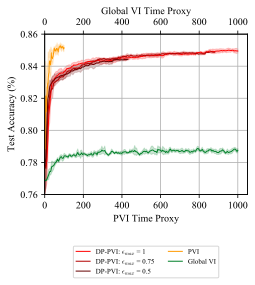

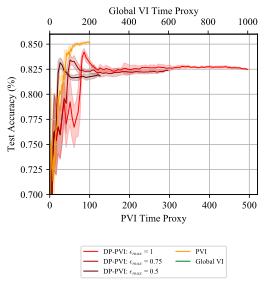

In [12]:
plot_methods_comms_rounds(all_homo_configs, all_homo_experiments, all_homo_metrics)
# plt.xlim([0, 200])
plt.ylim([0.83, 0.86])
plt.savefig('figs/homo_acc_time.pdf', format='pdf')

plot_methods_comms_rounds(all_inhomo_1_configs, all_inhomo_1_experiments, all_inhomo_1_metrics)
plt.ylim([0.76, 0.86])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_1_acc_time.pdf', format='pdf')

plot_methods_comms_rounds(all_inhomo_2_configs, all_inhomo_2_experiments, all_inhomo_2_metrics)
plt.ylim([0.70, 0.86])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_2_acc_time.pdf', format='pdf')


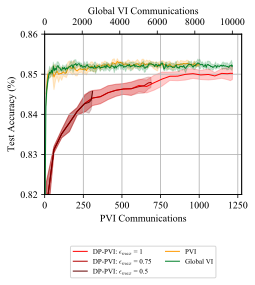

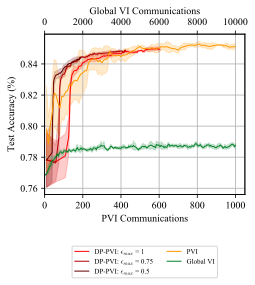

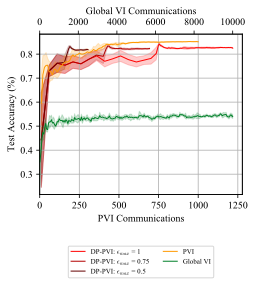

In [13]:
plot_methods_comms_rounds(all_homo_configs, all_homo_experiments, all_homo_metrics, metric_num=2)
plt.ylim([0.82, 0.86])
# plt.xlim([0, 200])
plt.savefig('figs/homo_acc_comms.pdf', format='pdf')


plot_methods_comms_rounds(all_inhomo_1_configs, all_inhomo_1_experiments, all_inhomo_1_metrics, metric_num=2)
# plt.ylim([0.82, 0.86])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_1_acc_comms.pdf', format='pdf')

plot_methods_comms_rounds(all_inhomo_2_configs, all_inhomo_2_experiments, all_inhomo_2_metrics, metric_num=2)
# plt.ylim([0.70, 0.86])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_2_acc_comms.pdf', format='pdf')

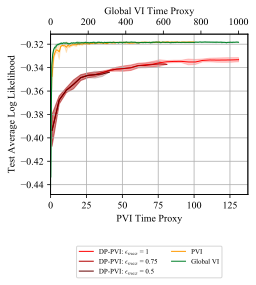

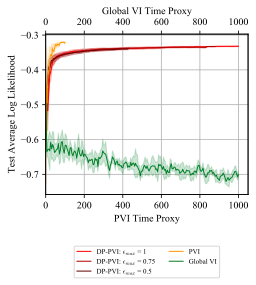

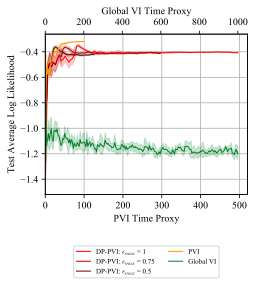

In [14]:
plot_methods_comms_rounds(all_homo_configs, all_homo_experiments, all_homo_metrics, metric_num=1)
# plt.xlim([0, 200])
plt.savefig('figs/homo_all_time.pdf', format='pdf')

plot_methods_comms_rounds(all_inhomo_1_configs, all_inhomo_1_experiments, all_inhomo_1_metrics, metric_num=1)
# plt.ylim([-3.2, -1.2])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_1_all_time.pdf', format='pdf')

plot_methods_comms_rounds(all_inhomo_2_configs, all_inhomo_2_experiments, all_inhomo_2_metrics, metric_num=1)
# plt.ylim([-3.2, -1.2])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_2_all_time.pdf', format='pdf')


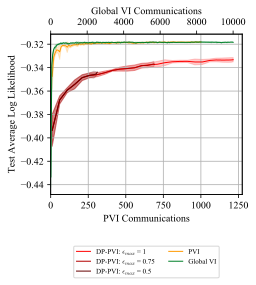

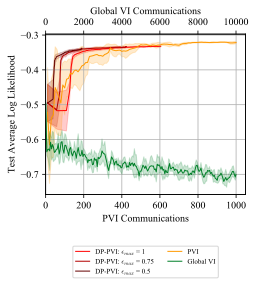

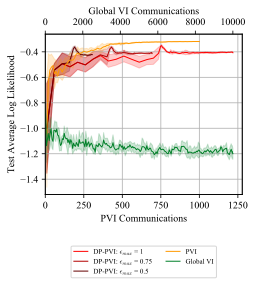

In [15]:
plot_methods_comms_rounds(all_homo_configs, all_homo_experiments, all_homo_metrics, metric_num=3)
# plt.xlim([0, 200])
plt.savefig('figs/homo_all_comms.pdf', format='pdf')

plot_methods_comms_rounds(all_inhomo_1_configs, all_inhomo_1_experiments, all_inhomo_1_metrics, metric_num=3)
# plt.ylim([-3.2, -1.2])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_1_all_comms.pdf', format='pdf')

plot_methods_comms_rounds(all_inhomo_2_configs, all_inhomo_2_experiments, all_inhomo_2_metrics, metric_num=3)
# plt.ylim([-3.2, -1.2])
# plt.xlim([0, 200])
plt.savefig('figs/inhomo_2_all_comms.pdf', format='pdf')


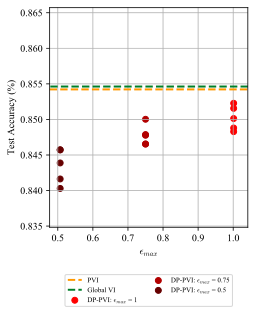

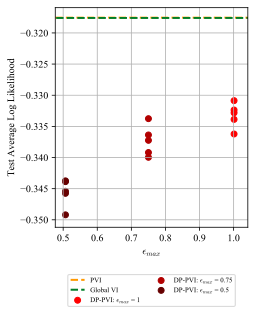

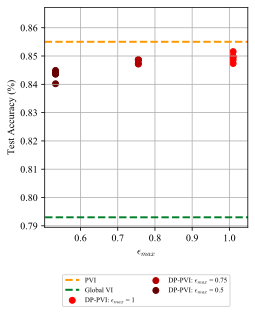

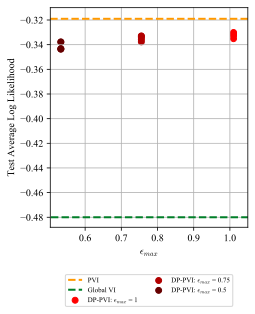

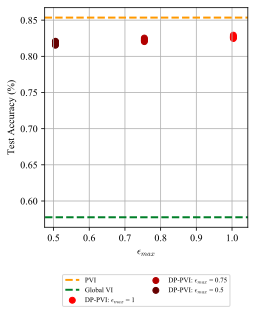

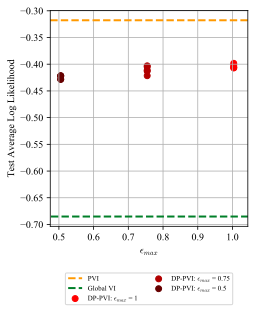

In [16]:
plot_methods_eps_final_only(pvi_homo_configs + batch_vi_homo_configs, 
                            pvi_homo_experiments + batch_vi_homo_experiments, 
                            pvi_homo_metrics + batch_vi_homo_metrics, 
                            dp_pvi_homo_configs, 
                            dp_pvi_homo_experiments, 
                            dp_pvi_homo_metrics , 
                            metric_num=0, epsilon_metric_indicies=[i+4 for i in range(10)])

plt.savefig('figs/homo_acc_best.pdf', format='pdf')

plot_methods_eps_final_only(pvi_homo_configs + batch_vi_homo_configs, 
                            pvi_homo_experiments + batch_vi_homo_experiments, 
                            pvi_homo_metrics + batch_vi_homo_metrics, 
                            dp_pvi_homo_configs, 
                            dp_pvi_homo_experiments, 
                            dp_pvi_homo_metrics, 
                            metric_num=1, epsilon_metric_indicies=[i+4 for i in range(10)])

plt.savefig('figs/homo_all_best.pdf', format='pdf')

plot_methods_eps_final_only(pvi_inhomo_1_configs + batch_vi_inhomo_1_configs, 
                            pvi_inhomo_1_experiments + batch_vi_inhomo_1_experiments, 
                            pvi_inhomo_1_metrics + batch_vi_inhomo_1_metrics, 
                            dp_pvi_inhomo_1_configs, 
                            dp_pvi_inhomo_1_experiments, 
                            dp_pvi_inhomo_1_metrics, 
                            metric_num=0, epsilon_metric_indicies=[i+4 for i in range(10)])

plt.savefig('figs/inhomo_1_acc_best.pdf', format='pdf')

plot_methods_eps_final_only(pvi_inhomo_1_configs + batch_vi_inhomo_1_configs, 
                            pvi_inhomo_1_experiments + batch_vi_inhomo_1_experiments, 
                            pvi_inhomo_1_metrics + batch_vi_inhomo_1_metrics, 
                            dp_pvi_inhomo_1_configs, 
                            dp_pvi_inhomo_1_experiments, 
                            dp_pvi_inhomo_1_metrics, 
                            metric_num=1, epsilon_metric_indicies=[i+4 for i in range(10)])

plt.savefig('figs/inhomo_1_all_best.pdf', format='pdf')

plot_methods_eps_final_only(pvi_inhomo_2_configs + batch_vi_inhomo_2_configs, 
                            pvi_inhomo_2_experiments + batch_vi_inhomo_2_experiments, 
                            pvi_inhomo_2_metrics + batch_vi_inhomo_2_metrics, 
                            dp_pvi_inhomo_2_configs, 
                            dp_pvi_inhomo_2_experiments, 
                            dp_pvi_inhomo_2_metrics, 
                            metric_num=0, epsilon_metric_indicies=[i+4 for i in range(10)])

plt.savefig('figs/inhomo_2_acc_best.pdf', format='pdf')

plot_methods_eps_final_only(pvi_inhomo_2_configs + batch_vi_inhomo_2_configs, 
                            pvi_inhomo_2_experiments + batch_vi_inhomo_2_experiments, 
                            pvi_inhomo_2_metrics + batch_vi_inhomo_2_metrics, 
                            dp_pvi_inhomo_2_configs, 
                            dp_pvi_inhomo_2_experiments, 
                            dp_pvi_inhomo_2_metrics, 
                            metric_num=1, epsilon_metric_indicies=[i+4 for i in range(10)])

plt.savefig('figs/inhomo_2_all_best.pdf', format='pdf')